In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

2024-06-14 18:15:36.499737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 18:15:36.499849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 18:15:36.686336: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data

In [2]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
(x_train_fashion_mnist, y_train_fashion_mnist), (x_test_fashion_mnist, y_test_fashion_mnist) = fashion_mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train_mnist = x_train_mnist/255
x_test_mnist = x_test_mnist/255

x_train_fashion_mnist = x_train_fashion_mnist/255
x_test_fashion_mnist = x_test_fashion_mnist/255

In [4]:
print("Shape of the train and test set of MNIST Dataset")
print(f"Train set: {x_train_mnist.shape}")
print(f"Test set: {x_test_mnist.shape}")

Shape of the train and test set of MNIST Dataset
Train set: (60000, 28, 28)
Test set: (10000, 28, 28)


In [5]:
print("Shape of the train and test set of Fashion-MNIST Dataset")
print(f"Train set: {x_train_fashion_mnist.shape}")
print(f"Test set: {x_test_fashion_mnist.shape}")

Shape of the train and test set of Fashion-MNIST Dataset
Train set: (60000, 28, 28)
Test set: (10000, 28, 28)


In [6]:
def show_example(data_train, data_test, title):
    
    np.random.seed(42)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.ravel()
    
    fig.suptitle(title, fontsize=16)
    axes[0].imshow(data_train[np.random.randint(len(data_train))], cmap='gray')
    axes[0].set_title("Train example")
    axes[0].axis('off')
    axes[1].imshow(data_test[np.random.randint(len(data_test))], cmap='gray')
    axes[1].set_title("Test example")
    axes[1].axis('off')
    
    plt.show()

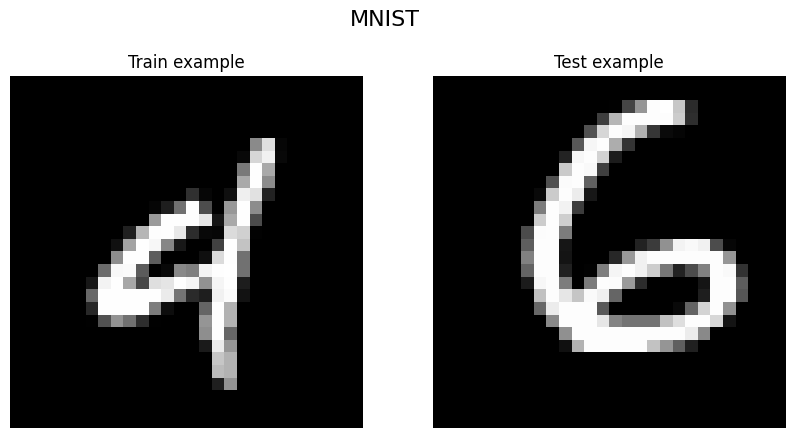

In [7]:
show_example(x_train_mnist, x_test_mnist, "MNIST")

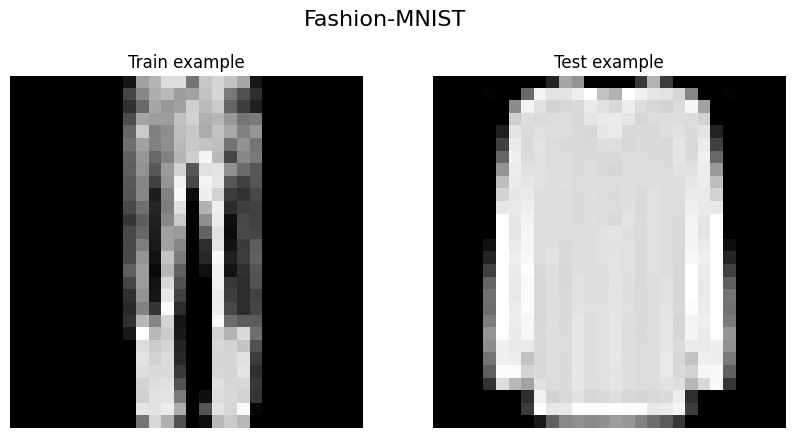

In [8]:
show_example(x_train_fashion_mnist, x_test_fashion_mnist, "Fashion-MNIST")

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(x_train_mnist, y_train_mnist, test_size=0.25, shuffle=True, random_state=42)
x_train_fashion_mnist, x_val_fashion_mnist, y_train_fashion_mnist, y_val_fashion_mnist = train_test_split(x_train_fashion_mnist, y_train_fashion_mnist, test_size=0.25, shuffle=True, random_state=42)

## Model

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from functools import reduce

In [31]:
class ConvAutoEncoder(tf.keras.Model):
    def __init__(self, input_shape=(28, 28, 1), latent_dim=6, name="Autoencoder"):
        super(ConvAutoEncoder, self).__init__(name=name)
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_shape)
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder(input_shape)
    
    def build_encoder(self, input_shape):
        encoder_input = Input(shape=input_shape)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_input)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        self.last_conv_shape = x.shape[1:]
        
        x = Flatten()(x)
        encoded = Dense(self.latent_dim, activation='relu')(x)
        
        return Model(encoder_input, encoded, name="Encoder")
    
    def build_decoder(self):
        latent_input = Input(shape=(self.latent_dim,))
        x = Dense(reduce(lambda x, y: x * y, self.last_conv_shape), activation='relu')(latent_input)
        x = Reshape(self.last_conv_shape)(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = ZeroPadding2D(padding=(2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
        x = ZeroPadding2D(padding=(2, 2))(x)
        x = Conv2DTranspose(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(x)
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)
        
        x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
        decoded = BatchNormalization()(x)
        
        return Model(latent_input, decoded, name="Decoder")
    
    def build_autoencoder(self, input_shape):
        autoencoder_input = Input(shape=input_shape)
        encoded = self.encoder(autoencoder_input)
        decoded = self.decoder(encoded)
        return Model(autoencoder_input, decoded, name=self.name)
    
    def call(self, inputs):
        return self.autoencoder(inputs)

### MNIST

In [35]:
mnist_autoencoder = ConvAutoEncoder(name="mnist_autoencoder")

learning_rate = 5e-4
mnist_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse', 'mae'])

In [36]:
mnist_autoencoder.encoder.summary()
mnist_autoencoder.decoder.summary()
mnist_autoencoder.autoencoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,190 (395.27 KB)

 Trainable params: 100,710 (393.40 KB)

 Non-trainable params: 480 (1.88 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 2, 2, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_12               │ (None, 4, 4, 128)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_13               │ (None, 10, 10, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 20, 20, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 20, 20, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_14               │ (None, 24, 24, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 24, 24, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 24, 24, 32)     │           12

 Total params: 445,749 (1.70 MB)

 Trainable params: 445,011 (1.70 MB)

 Non-trainable params: 738 (2.88 KB)

Model: "mnist_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 6)              │       101,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 28, 28, 1)      │       445,749 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 546,939 (2.09 MB)

 Trainable params: 545,721 (2.08 MB)

 Non-trainable params: 1,218 (4.76 KB)

In [37]:
history_mnist = mnist_autoencoder.fit(x_train_mnist, x_train_mnist, epochs=10, batch_size=256, validation_data=(x_val_mnist, x_val_mnist))

Epoch 1/10
  5/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.2302 - mae: 0.4717 - mse: 0.2302

W0000 00:00:1718389351.671818     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - loss: 0.1516 - mae: 0.3327 - mse: 0.1516 - val_loss: 0.0662 - val_mae: 0.1560 - val_mse: 0.0662
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0642 - mae: 0.1512 - mse: 0.0642 - val_loss: 0.0512 - val_mae: 0.1211 - val_mse: 0.0512
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0470 - mae: 0.1130 - mse: 0.0470 - val_loss: 0.0382 - val_mae: 0.0917 - val_mse: 0.0382
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0361 - mae: 0.0880 - mse: 0.0361 - val_loss: 0.0327 - val_mae: 0.0805 - val_mse: 0.0327
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0317 - mae: 0.0788 - mse: 0.0317 - val_loss: 0.0302 - val_mae: 0.0749 - val_mse: 0.0302
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0297 - mae: 0.0749 - mse: 0.0297 - val_loss: 0.0284 - val_mae: 0.0730 - val_mse: 0.0284
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0282 - mae: 0.0722 - mse: 0.0282 - val_lo

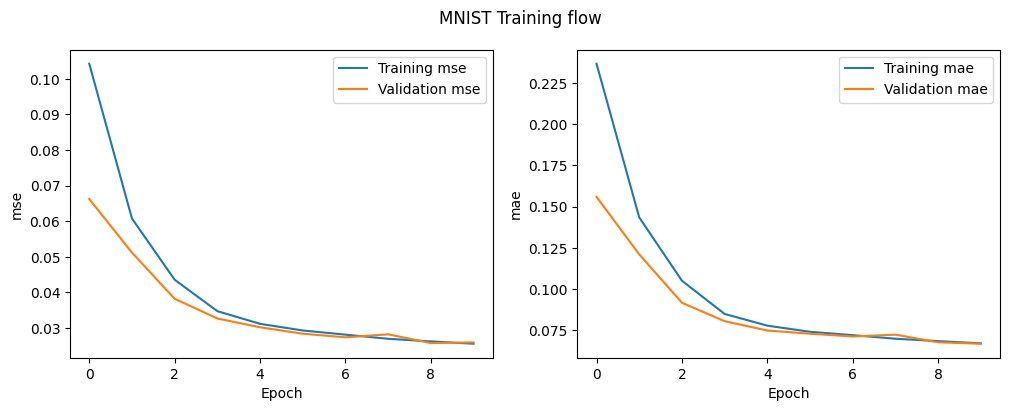

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

for i, metric in enumerate(['mse', 'mae']):
    axes[i].plot(history_mnist.history[metric], label=f"Training {metric}")
    axes[i].plot(history_mnist.history[f"val_{metric}"], label=f"Validation {metric}")
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric)
    axes[i].legend()

plt.suptitle("MNIST Training flow")
plt.show()

In [39]:
results = mnist_autoencoder.evaluate(x_test_mnist, x_test_mnist)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0258 - mae: 0.0667 - mse: 0.0258


In [40]:
predictions_mnist = mnist_autoencoder.predict(np.expand_dims(x_test_mnist, axis=-1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


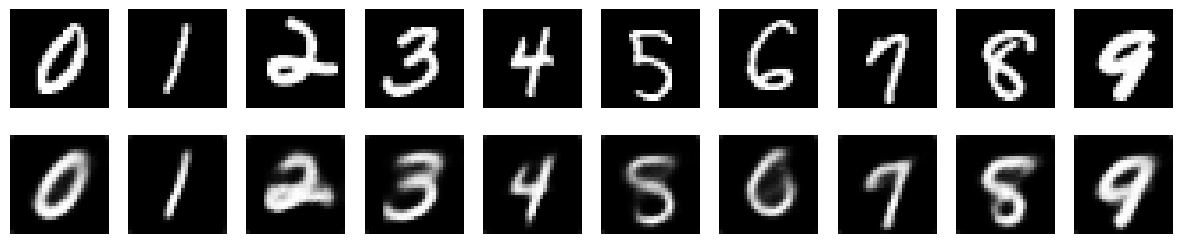

In [41]:
np.random.seed(0)
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
axes = axes.flatten()

for i in range(10):
    index = np.random.choice(np.where(y_test_mnist == i)[0])
    axes[i].imshow(x_test_mnist[index], cmap='gray')
    axes[i].axis('off')
    axes[i+10].imshow(predictions_mnist[index], cmap='gray')
    axes[i+10].axis('off')

plt.show()

In [42]:
mnist_train_vec = mnist_autoencoder.encoder(np.expand_dims(x_train_mnist, axis=-1))
mnist_test_vec = mnist_autoencoder.encoder(np.expand_dims(x_test_mnist, axis=-1))
mnist_val_vec = mnist_autoencoder.encoder(np.expand_dims(x_val_mnist, axis=-1))

### Clustering

In [43]:
mnist_vec = tf.concat([mnist_train_vec, mnist_test_vec, mnist_val_vec], axis=0).numpy()
mnist_label = np.concatenate((y_train_mnist, y_test_mnist, y_val_mnist), axis=0)

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [46]:
silhouette_scores= []
best_silhouette_score = -1
best_n_clusters = 0

for n_clusters in range(5, 16):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(mnist_vec)
    
    silhouette_avg = silhouette_score(mnist_vec, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters} with a silhouette score of {best_silhouette_score}")

For n_clusters = 5, the silhouette score is 0.18184994161128998
For n_clusters = 6, the silhouette score is 0.18320955336093903
For n_clusters = 7, the silhouette score is 0.18463055789470673
For n_clusters = 8, the silhouette score is 0.18151958286762238
For n_clusters = 9, the silhouette score is 0.18070738017559052
For n_clusters = 10, the silhouette score is 0.17854805290699005
For n_clusters = 11, the silhouette score is 0.1851474642753601
For n_clusters = 12, the silhouette score is 0.187272846698761
For n_clusters = 13, the silhouette score is 0.18523894250392914
For n_clusters = 14, the silhouette score is 0.18241384625434875
For n_clusters = 15, the silhouette score is 0.18310332298278809

Best number of clusters: 12 with a silhouette score of 0.187272846698761


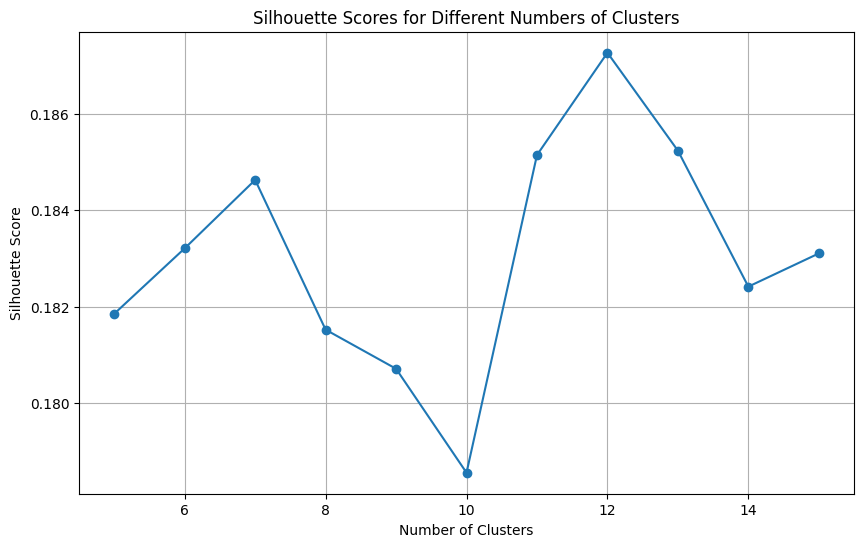

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(5, 16), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.grid(True)
plt.show()

In [48]:
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
best_kmeans.fit(mnist_vec)
best_labels = best_kmeans.labels_

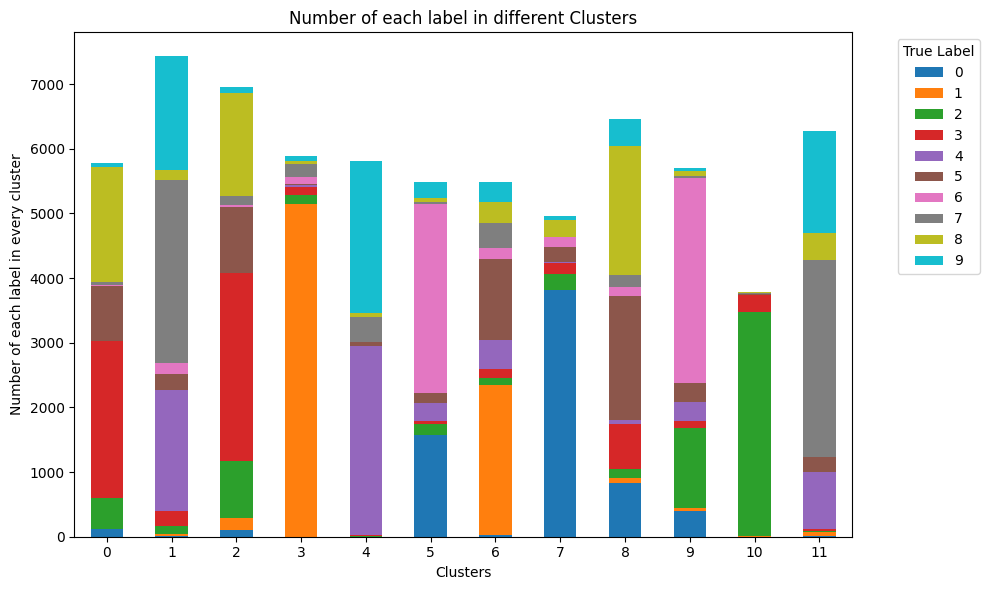

In [49]:
df = pd.DataFrame({'TrueLabel': mnist_label, 'ClusterLabel': best_labels})

count_per_cluster = df.groupby(['ClusterLabel', 'TrueLabel']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
count_per_cluster.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Number of each label in different Clusters')
ax.set_xlabel('Clusters')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Number of each label in every cluster')
plt.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Fashion-MNIST

In [69]:
fashion_mnist_autoencoder = ConvAutoEncoder(name="fashion_mnist_autoencoder")

learning_rate = 1e-3
fashion_mnist_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse', 'mae'])

In [70]:
fashion_mnist_autoencoder.encoder.summary()
fashion_mnist_autoencoder.decoder.summary()
fashion_mnist_autoencoder.autoencoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,190 (395.27 KB)

 Trainable params: 100,710 (393.40 KB)

 Non-trainable params: 480 (1.88 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (None, 2, 2, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_24               │ (None, 4, 4, 128)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_55             │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_56             │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_25               │ (None, 10, 10, 64)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_57             │ (None, 20, 20, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 20, 20, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_26               │ (None, 24, 24, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ (None, 24, 24, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 24, 24, 32)     │           12

 Total params: 445,749 (1.70 MB)

 Trainable params: 445,011 (1.70 MB)

 Non-trainable params: 738 (2.88 KB)

Model: "fashion_mnist_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 6)              │       101,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 28, 28, 1)      │       445,749 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 546,939 (2.09 MB)

 Trainable params: 545,721 (2.08 MB)

 Non-trainable params: 1,218 (4.76 KB)

In [71]:
history_fashion_mnist = fashion_mnist_autoencoder.fit(x_train_fashion_mnist, x_train_fashion_mnist,
                                                      epochs=10, batch_size=256, validation_data=(x_val_fashion_mnist, x_val_fashion_mnist))

Epoch 1/10
  5/176 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.1684 - mae: 0.3803 - mse: 0.1684

W0000 00:00:1718392296.764092     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.1121 - mae: 0.2864 - mse: 0.1121 - val_loss: 0.0638 - val_mae: 0.1874 - val_mse: 0.0638
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0531 - mae: 0.1616 - mse: 0.0531 - val_loss: 0.0407 - val_mae: 0.1324 - val_mse: 0.0407
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0399 - mae: 0.1294 - mse: 0.0399 - val_loss: 0.0382 - val_mae: 0.1240 - val_mse: 0.0382
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0377 - mae: 0.1233 - mse: 0.0377 - val_loss: 0.0370 - val_mae: 0.1218 - val_mse: 0.0370
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0366 - mae: 0.1202 - mse: 0.0366 - val_loss: 0.0356 - val_mae: 0.1163 - val_mse: 0.0356
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0355 - mae: 0.1175 - mse: 0.0355 - val_loss: 0.0351 - val_mae: 0.1158 - val_mse: 0.0351
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0349 - mae: 0.1157 - mse: 0.0349 - val_lo

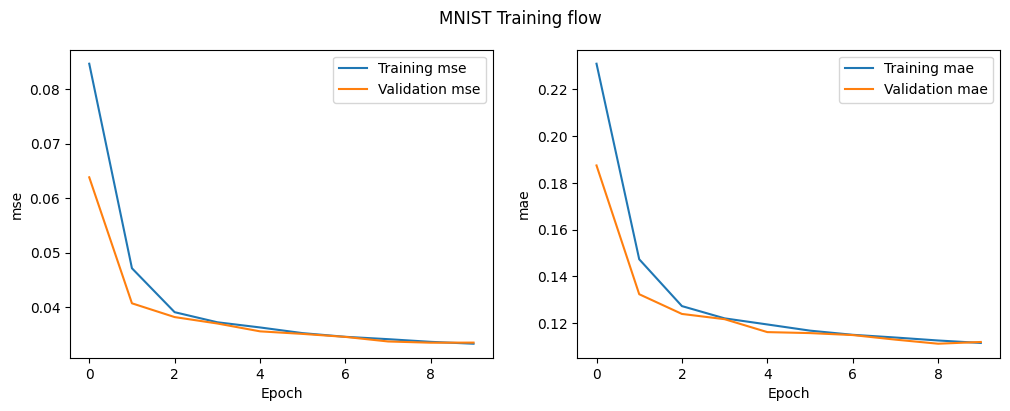

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

for i, metric in enumerate(['mse', 'mae']):
    axes[i].plot(history_fashion_mnist.history[metric], label=f"Training {metric}")
    axes[i].plot(history_fashion_mnist.history[f"val_{metric}"], label=f"Validation {metric}")
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(metric)
    axes[i].legend()

plt.suptitle("MNIST Training flow")
plt.show()

In [73]:
results = fashion_mnist_autoencoder.evaluate(x_test_fashion_mnist, x_test_fashion_mnist)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0334 - mae: 0.1120 - mse: 0.0334


In [74]:
predictions_fashion_mnist = fashion_mnist_autoencoder.predict(np.expand_dims(x_test_fashion_mnist, axis=-1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


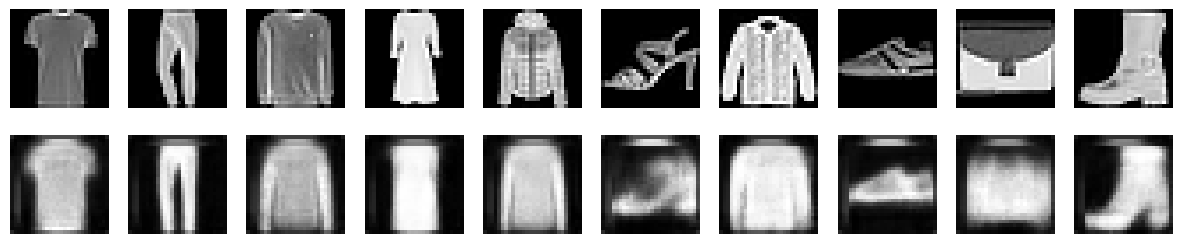

In [75]:
np.random.seed(0)
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
axes = axes.flatten()

for i in range(10):
    index = np.random.choice(np.where(y_test_fashion_mnist == i)[0])
    axes[i].imshow(x_test_fashion_mnist[index], cmap='gray')
    axes[i].axis('off')
    axes[i+10].imshow(predictions_fashion_mnist[index], cmap='gray')
    axes[i+10].axis('off')

plt.show()

In [76]:
fashion_mnist_train_vec = fashion_mnist_autoencoder.encoder(np.expand_dims(x_train_fashion_mnist, axis=-1))
fashion_mnist_test_vec = fashion_mnist_autoencoder.encoder(np.expand_dims(x_test_fashion_mnist, axis=-1))
fashion_mnist_val_vec = fashion_mnist_autoencoder.encoder(np.expand_dims(x_val_fashion_mnist, axis=-1))

### Clustering

In [77]:
fashion_mnist_vec = tf.concat([fashion_mnist_train_vec, fashion_mnist_test_vec, fashion_mnist_val_vec], axis=0).numpy()
fashion_mnist_label = np.concatenate((y_train_fashion_mnist, y_test_fashion_mnist, y_val_fashion_mnist), axis=0)

In [78]:
silhouette_scores= []
best_silhouette_score = -1
best_n_clusters = 0

for n_clusters in range(5, 16):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(fashion_mnist_vec)
    
    silhouette_avg = silhouette_score(fashion_mnist_vec, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg}")
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters} with a silhouette score of {best_silhouette_score}")

For n_clusters = 5, the silhouette score is 0.4141753613948822
For n_clusters = 6, the silhouette score is 0.3985285758972168
For n_clusters = 7, the silhouette score is 0.39932572841644287
For n_clusters = 8, the silhouette score is 0.4120921194553375
For n_clusters = 9, the silhouette score is 0.41658449172973633
For n_clusters = 10, the silhouette score is 0.38909435272216797
For n_clusters = 11, the silhouette score is 0.3883828818798065
For n_clusters = 12, the silhouette score is 0.3835880160331726
For n_clusters = 13, the silhouette score is 0.3877197802066803
For n_clusters = 14, the silhouette score is 0.3922213912010193
For n_clusters = 15, the silhouette score is 0.40020227432250977

Best number of clusters: 9 with a silhouette score of 0.41658449172973633


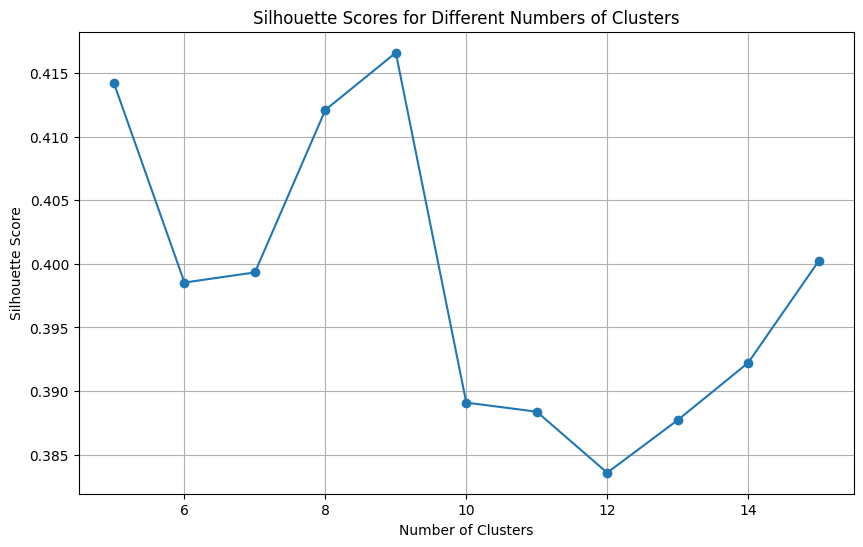

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(range(5, 16), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.grid(True)
plt.show()

In [80]:
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
best_kmeans.fit(fashion_mnist_vec)
best_labels = best_kmeans.labels_

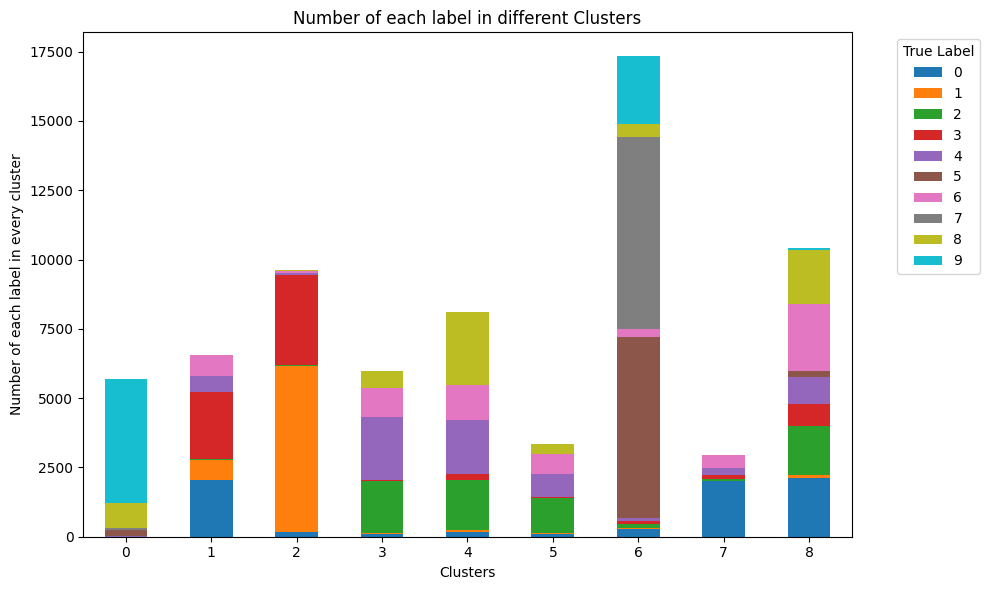

In [81]:
df = pd.DataFrame({'TrueLabel': fashion_mnist_label, 'ClusterLabel': best_labels})

count_per_cluster = df.groupby(['ClusterLabel', 'TrueLabel']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
count_per_cluster.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Number of each label in different Clusters')
ax.set_xlabel('Clusters')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Number of each label in every cluster')
plt.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()